### DCGANs `MNIST` dataset.

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Reshape, Conv2DTranspose, MaxPooling2D, UpSampling2D, LeakyReLU
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
from packaging.version import parse as parse_version

### Loading the `mnist` dataset.

In [3]:

(ds_train, ds_test_), ds_info = tfds.load('mnist', 
                              split=['train', 'test'], 
                              shuffle_files=True,
                              as_supervised=True,
                              with_info=True)


batch_size = 256
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = image/255.
    return image, image


ds_train = ds_train.map(preprocess)
ds_train = ds_train.cache() # put dataset into memory
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)

ds_test = ds_test_.map(preprocess).batch(batch_size).cache().prefetch(batch_size)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling mnist-train.tfrecord...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling mnist-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset mnist downloaded and prepared to C:\Users\crisp\tensorflow_datasets\mnist\3.0.1. Subsequent calls will reuse this data.


In [ ]:

# return label for testing
def preprocess_with_label(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.math.round(image/255.)
    return image, label

ds_test_label = ds_test_.map(preprocess_with_label).batch(1000)

In [4]:
def Encoder(z_dim):
    inputs  = layers.Input(shape=[28,28,1])
    
    x = inputs    
    x = Conv2D(filters=8,  kernel_size=(3,3), strides=2, padding='same', activation='relu')(x)
    x = Conv2D(filters=8,  kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = Conv2D(filters=8,  kernel_size=(3,3), strides=2, padding='same', activation='relu')(x)
    x = Conv2D(filters=8,  kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = Flatten()(x)
    out = Dense(z_dim)(x)
    
    return Model(inputs=inputs, outputs=out, name='encoder')

def Decoder(z_dim):
    inputs  = layers.Input(shape=[z_dim])
    x = inputs    
    x = Dense(7*7*64, activation='relu')(x)
    x = Reshape((7,7,64))(x)

    x = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = UpSampling2D((2,2))(x)
    
    x = Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = UpSampling2D((2,2))(x)    

    out = Conv2D(filters=1, kernel_size=(3,3), strides=1, padding='same', activation='sigmoid')(x)
    
    #return out          
    return Model(inputs=inputs, outputs=out, name='decoder')

class Autoencoder:
    def __init__(self, z_dim):
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        
        model_input = self.encoder.input
        model_output = self.decoder(self.encoder.output)
        self.model = Model(model_input, model_output)

In [5]:
autoencoder = Autoencoder(z_dim=10)

In [6]:
model_path = "./models/autoencoder.h5"
os.makedirs("./models", exist_ok=True)

checkpoint = ModelCheckpoint(model_path, 
                             monitor= "val_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "auto", 
                             save_weights_only = False)

early = EarlyStopping(monitor= "val_loss", 
                      mode= "auto", 
                      patience = 5)

callbacks_list = [checkpoint, early]

autoencoder.model.compile(
    loss = "mse",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=3e-4))
    #metrics=[tf.keras.losses.BinaryCrossentropy()])
autoencoder.model.fit(ds_train, validation_data=ds_test,
                epochs = 100, callbacks = callbacks_list)

Epoch 1/100
235/235 [==============================] - 181s 704ms/step - loss: 0.0930 - val_loss: 0.0406

Epoch 00001: val_loss improved from inf to 0.04057, saving model to ./models\autoencoder.h5
Epoch 2/100
235/235 [==============================] - 154s 656ms/step - loss: 0.0363 - val_loss: 0.0290

Epoch 00002: val_loss improved from 0.04057 to 0.02905, saving model to ./models\autoencoder.h5
Epoch 3/100
235/235 [==============================] - 153s 651ms/step - loss: 0.0286 - val_loss: 0.0248

Epoch 00003: val_loss improved from 0.02905 to 0.02481, saving model to ./models\autoencoder.h5
Epoch 4/100
235/235 [==============================] - 158s 673ms/step - loss: 0.0253 - val_loss: 0.0237

Epoch 00004: val_loss improved from 0.02481 to 0.02366, saving model to ./models\autoencoder.h5
Epoch 5/100
235/235 [==============================] - 151s 643ms/step - loss: 0.0234 - val_loss: 0.0230

Epoch 00005: val_loss improved from 0.02366 to 0.02303, saving model to ./models\autoencod

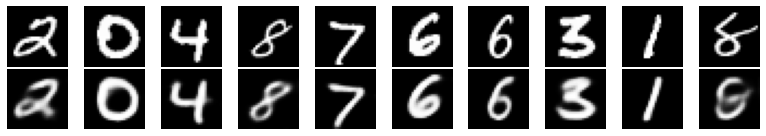

In [7]:
images, labels = next(iter(ds_test))
autoencoder.model = load_model(model_path)
outputs = autoencoder.model.predict(images)

# Display
grid_col = 10
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.1, grid_row))

i = 0
for row in range(0, grid_row, 2):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row,col].axis('off')
        axarr[row+1,col].imshow(outputs[i,:,:,0], cmap='gray')
        axarr[row+1,col].axis('off')        
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)        
plt.show()